In [1]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install xgboost
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import train_test_split

import shap
import xgboost as xgb

shap.initjs()

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read dataset

In [3]:
csv_path = "fastf1_lap_dataset.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)
df = df.drop("grid_position", axis=1)

# Remove ever row where is_pit is True
df = df[df['is_pit'] == False]

df['current_position'] = df['current_position'].fillna(method='ffill')
df['lap_time_s'] = df['lap_time_s'].fillna(method='ffill').fillna(method='bfill')
df['tyre_compound'] = df['tyre_compound'].fillna(method='ffill')
df['laps_on_current_tyre'] = df['laps_on_current_tyre'].fillna(df['laps_on_current_tyre'].median())

print(df.isna().sum())
df[df.isna().any(axis=1)]

driver_id               0
team_id                 0
circuit_id              0
total_race_laps         0
year                    0
session_name            0
current_position        0
gap_to_leader_s         0
gap_to_ahead_s          0
lap_time_s              0
laps_on_current_tyre    0
tyre_compound           0
safety_car_this_lap     0
lap_number              0
drs_enabled             0
track_temperature       0
air_temperature         0
has_rain                0
is_pit                  0
session_key             0
race_name               0
team_name               0
virtual_sc_this_lap     0
humidity                0
pressure                0
rainfall                0
wind_speed              0
wind_direction          0
dtype: int64


/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['current_position'] = df['current_position'].fillna(method='ffill')
/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lap_time_s'] = df['lap_time_s'].fillna(method='ffill').fillna(method='bfill')
/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_68407/363405642.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['tyre_compound'] = df['tyre_compound'].fillna(method='ffill')


Empty DataFrame
Columns: [driver_id, team_id, circuit_id, total_race_laps, year, session_name, current_position, gap_to_leader_s, gap_to_ahead_s, lap_time_s, laps_on_current_tyre, tyre_compound, safety_car_this_lap, lap_number, drs_enabled, track_temperature, air_temperature, has_rain, is_pit, session_key, race_name, team_name, virtual_sc_this_lap, humidity, pressure, rainfall, wind_speed, wind_direction]
Index: []

[0 rows x 28 columns]

# Format Dataset

In [4]:
import numpy as np

race_df = df[
    (~df["safety_car_this_lap"]) &
    (~df["virtual_sc_this_lap"]) &
    df["lap_time_s"].notna()
].copy()

circuit_baseline = (
    race_df
    .groupby("circuit_id")["lap_time_s"]
    .median()
    .reset_index()
    .rename(columns={"lap_time_s": "circuit_median_lap"})
)

df = df.merge(circuit_baseline, on="circuit_id", how="left")

df["lap_delta_s"] = df["lap_time_s"] - df["circuit_median_lap"]

# ------------------------------------------------------------------
# Driver skill metric
# ------------------------------------------------------------------

session_col = "session_key"
clean_laps_for_skill = df[
    (~df["safety_car_this_lap"]) &
    (~df["virtual_sc_this_lap"]) &
    df["lap_time_s"].notna()
].copy()

session_stats = (
    clean_laps_for_skill
    .groupby(session_col)["lap_time_s"]
    .agg(session_median_lap="median", session_std_lap="std")
    .reset_index()
)

clean_laps_for_skill = clean_laps_for_skill.merge(
    session_stats,
    on=session_col,
    how="left",
)

clean_laps_for_skill["session_std_lap"] = clean_laps_for_skill["session_std_lap"].replace(0, np.nan)

clean_laps_for_skill["session_perf_z"] = -(
    clean_laps_for_skill["lap_time_s"] - clean_laps_for_skill["session_median_lap"]
) / clean_laps_for_skill["session_std_lap"]

clean_laps_for_skill["session_perf_z"] = clean_laps_for_skill["session_perf_z"].fillna(0.0)

driver_session_skill = (
    clean_laps_for_skill
    .groupby(["driver_id", session_col])["session_perf_z"]
    .mean()
    .reset_index()
)

driver_skill_raw = (
    driver_session_skill
    .groupby("driver_id")["session_perf_z"]
    .mean()
)

driver_skill = (driver_skill_raw - driver_skill_raw.mean()) / driver_skill_raw.std()

df = df.merge(
    driver_skill.rename("driver_skill"),
    on="driver_id",
    how="left",
)

df["driver_skill"] = df["driver_skill"].fillna(0.0)

df["race_progress"] = df["lap_number"] / df["total_race_laps"]
df["laps_remaining"] = df["total_race_laps"] - df["lap_number"]

filtered_df = df[[
    #"driver_id",
    "circuit_id",
    "laps_on_current_tyre",
    "tyre_compound",
    #"lap_number",
    "race_progress",
    #"laps_remaining",
    "rainfall",
    "current_position",
    "gap_to_ahead_s",
    "year",
    "driver_skill",
    "lap_delta_s",
]].copy()

#filtered_df["driver_id"] = filtered_df["driver_id"].astype("category")
filtered_df["circuit_id"] = filtered_df["circuit_id"].astype("category")
filtered_df["tyre_compound"] = filtered_df["tyre_compound"].astype("category")

#driver_cat = filtered_df["driver_id"].dtype
circuit_cat = filtered_df["circuit_id"].dtype
compound_cat = filtered_df["tyre_compound"].dtype

circuit_median_map = circuit_baseline.set_index("circuit_id")["circuit_median_lap"].to_dict()
driver_skill_map = driver_skill.to_dict()


In [5]:
driver_skill_map

{'AIT': 0.07382246613394057,
 'ALB': 0.16389569928037115,
 'ALO': 0.1957102266324713,
 'ANT': 0.6530232609427813,
 'BEA': 0.10330284883760386,
 'BOR': -0.24160655484037788,
 'BOT': 0.5279169466568518,
 'COL': -0.43786620960427686,
 'DEV': -0.19732569958024251,
 'DOO': -4.8582650704519175,
 'ERI': -0.20089707051791594,
 'FIT': -0.11016230017201759,
 'GAS': 0.17983434307073534,
 'GIO': -0.21978182760128728,
 'GRO': -0.18952707173318808,
 'HAD': 0.14165348975457975,
 'HAM': 1.3963939479732745,
 'HAR': -0.728161644346584,
 'HUL': 0.055249090344850406,
 'KUB': -1.462059824647062,
 'KVY': 0.13371559831526014,
 'LAT': -0.42318606168041567,
 'LAW': -0.21171664638876309,
 'LEC': 1.0866422470120505,
 'MAG': -0.16358237933588096,
 'MAZ': -1.3084619660858368,
 'MSC': -0.4078152790077036,
 'NOR': 1.061308227152902,
 'OCO': -0.17835863631860366,
 'PER': 0.9253318315312046,
 'PIA': 1.2583612174379308,
 'RAI': 0.28706862973090147,
 'RIC': 0.4612099985691684,
 'RUS': 0.6332478117391315,
 'SAI': 0.76287

In [6]:
circuit_cat

CategoricalDtype(categories=['austin', 'baku', 'barcelona', 'budapest', 'hockenheim',
                  'imola', 'istanbul', 'jeddah', 'las_vegas', 'le_castellet',
                  'lusail', 'marina_bay', 'melbourne', 'mexico_city', 'miami',
                  'miami_gardens', 'monaco', 'monte_carlo', 'montréal',
                  'monza', 'mugello', 'nürburgring', 'portimão', 'sakhir',
                  'shanghai', 'silverstone', 'singapore', 'sochi',
                  'spa_francorchamps', 'spielberg', 'suzuka', 'são_paulo',
                  'yas_island', 'yas_marina', 'zandvoort'],
, ordered=False, categories_dtype=object)

In [7]:
driver_cat

NameError: name 'driver_cat' is not defined

In [8]:
compound_cat

CategoricalDtype(categories=['HARD', 'HYPERSOFT', 'INTERMEDIATE', 'MEDIUM', 'SOFT',
                  'SUPERSOFT', 'ULTRASOFT', 'UNKNOWN', 'WET'],
, ordered=False, categories_dtype=object)

In [9]:
X = filtered_df.drop("lap_delta_s", axis=1)
y = filtered_df["lap_delta_s"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Search for the best params

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Your param grid
param_dist = {
    "max_depth": [3, 4, 5, 6, 7],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.1, 1, 5, 10],
    "reg_alpha": [0.0, 0.1, 1.0],
}

base_model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,
    reg_lambda=1.0,
)


search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best validation RMSE:", -search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 1.0}
Best validation RMSE: 4.183812593199043


## With driverID and skill

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'min_child_weight': 3, 'max_depth': 7, 'colsample_bytree': 0.9}

Best validation RMSE: 5.2050096718910215

Test RMSE: 4.835361628140747

## With skill only 

Test RMSE: 4.86 (little bit worse)

## Skill & Lap Progress & Laps remaining

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.0, 'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 1.0}

Best validation RMSE: 4.175806651822845

Test RMSE: 3.8351028408185766

## Skill & Lap Progress without laps remaining

Fitting 1 folds for each of 30 candidates, totalling 30 fits

Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'min_child_weight': 1, 'max_depth': 7, 'colsample_bytree': 0.9}

Best validation RMSE: 4.536415633140397

Test RMSE: 4.178373330741852


In [11]:
model = search.best_estimator_

In [77]:
model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.05,
    random_state=42,

    subsample=1,
    reg_lambda=5,
    reg_alpha=1.0,
    min_alpha=1,
    max_depth=7,
    colsample_bytree=1
)

model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [11:10:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "min_alpha" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None, min_alpha=1,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None, ...)

Sample predictions: [0.84662956 4.181719   4.181698   1.703087   6.2087307 ]
[[-7.72424281e-01 -8.24005663e-01 -1.25810635e+00 ...  1.22277701e+00
  -2.05109549e+00 -2.11996213e-01]
 [-1.33961403e+00  2.12930799e+00 -1.25097823e+00 ... -2.48230413e-01
   1.81680441e+00  4.23230380e-01]
 [ 5.06551657e-03 -3.29265952e+00  7.69244146e+00 ...  6.86984539e-01
  -7.50985742e-01 -2.74477392e-01]
 ...
 [-5.84811270e-01 -2.21135855e-01 -5.94583511e-01 ... -9.51772556e-02
   1.53587729e-01 -1.23942606e-01]
 [-6.95296764e-01  4.41100657e-01 -4.11890864e-01 ... -6.31164432e-01
   1.78595352e+00  6.18996322e-01]
 [ 7.26519442e+00  7.91507512e-02 -7.11049289e-02 ... -4.45889443e-01
   4.48091555e+00  1.51806688e-02]]


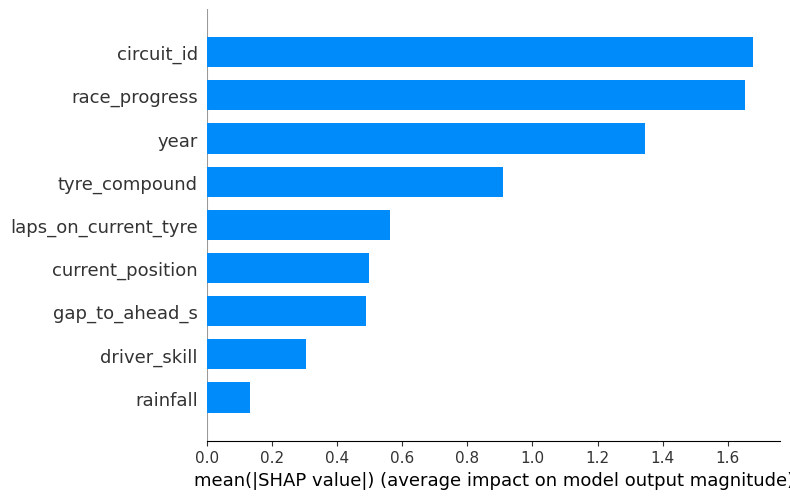

In [12]:
# 4. Predict on test set
preds = model.predict(X_test)
print("Sample predictions:", preds[:5])

# 5. Compute SHAP values
explainer = shap.TreeExplainer(model)

test_sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test[:test_sample_size]

shap_values_test = explainer.shap_values(X_test_sample)

print(shap_values_test)

# 6. SHAP summary plot
shap.summary_plot(
    shap_values_test,
    X_test_sample,
    plot_type="bar"
)

# Real FULL race simulation

In [13]:
import ipynb.fs.defs.overtaking_model as overtaking_model
import ipynb.fs.defs.dnf_model as dnf_model
import ipynb.fs.defs.safety_car_model as safety_car_model

# Build overtaking model using shared class (uses df and driver_skill_map from earlier)
ot_model = overtaking_model.OvertakingModel(
    df=df,
    driver_skill_map=driver_skill_map,
    include_year=True,
)

overtake_stats = ot_model.overtake_stats
circuit_overtake_ease = ot_model.circuit_overtake_ease
overtake_stats_by_year = ot_model.overtake_stats_by_year
circuit_year_overtake_ease = ot_model.circuit_year_overtake_ease

# Build DNF model
hazard_model = dnf_model.DNFModel(include_year=True)
dnf_stats = hazard_model.dnf_stats
dnf_stats_by_year = hazard_model.dnf_stats_by_year

# Build Safety Car/VSC generative model
sc_gen_model = safety_car_model.SafetyCarGenerativeModel(include_year=True)


/Users/ekazuki/Documents/f1stuff/models/safety_car_model.ipynb:105: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  "        laps['safety_car_this_lap'] = laps['safety_car_this_lap'].astype(bool)\n",
/Users/ekazuki/Documents/f1stuff/models/safety_car_model.ipynb:106: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  "        laps['virtual_sc_this_lap'] = laps['virtual_sc_this_lap'].astype(bool)\n",


In [84]:
overtake_stats

overtakes  opportunities  raw_rate  overtake_rate  \
circuit_id                                                             
austin                   926           1504  0.615691       0.606028   
baku                     753           1427  0.527680       0.528379   
barcelona               1164           1466  0.793997       0.762708   
budapest                 966           1618  0.597033       0.590029   
hockenheim               315            391  0.805627       0.713489   
imola                    534           1341  0.398210       0.415751   
istanbul                 167            255  0.654902       0.601477   
jeddah                   362           1059  0.341832       0.372257   
las_vegas                452            753  0.600266       0.586225   
le_castellet             410            737  0.556309       0.551411   
lusail                   604           1272  0.474843       0.482794   
marina_bay               415            987  0.420466       0.439488   
melbourne                479           1333  0.359340       0.382043   
mexico_city              813           1385  0.587004       0.580235   
miami                    365           1053  0.346629       0.376434   
miami_gardens            105            268  0.391791       0.452291   
monaco                   226           1367  0.165326       0.212299   
monte_carlo              192            771  0.249027       0.307592   
montréal                 635           1842  0.344734       0.363209   
monza                    905           2031  0.445593       0.453461   
mugello                   63             97  0.649485       0.571286   
nürburgring              164            211  0.777251       0.658569   
portimão                 269            443  0.607223       0.584249   
sakhir                  1354           1900  0.712632       0.695558   
shanghai                 579           1181  0.490262       0.496504   
silverstone              852           2139  0.398317       0.409864   
singapore                241            426  0.565728       0.555387   
sochi                    452            662  0.682779       0.648111   
spa_francorchamps        732           1515  0.483168       0.489022   
spielberg               1461           3122  0.467969       0.471906   
suzuka                   629            958  0.656576       0.635295   
são_paulo               1225           2877  0.425791       0.432783   
yas_island               912           1270  0.718110       0.692974   
yas_marina               121            124  0.975806       0.702692   
zandvoort                611           1607  0.380212       0.397162   

                   enough_data  overtake_ease  
circuit_id                                     
austin                    True       0.723963  
baku                      True       0.481760  
barcelona                 True       0.950000  
budapest                  True       0.674058  
hockenheim                True       0.950000  
imola                     True       0.130453  
istanbul                  True       0.709768  
jeddah                    True       0.050000  
las_vegas                 True       0.662192  
le_castellet              True       0.553602  
lusail                    True       0.339571  
marina_bay                True       0.204493  
melbourne                 True       0.050000  
mexico_city               True       0.643509  
miami                     True       0.050000  
miami_gardens             True       0.244428  
monaco                    True       0.050000  
monte_carlo               True       0.050000  
montréal                  True       0.050000  
monza                     True       0.248079  
mugello                   True       0.615597  
nürburgring               True       0.887849  
portimão                  True       0.656030  
sakhir                    True       0.950000  
shanghai                  True       0.382337  
silverstone               True       0.112091  
singapore 

In [16]:
def format_seconds(seconds):
    """Format seconds as M:SS.sss"""
    if seconds is None or np.isnan(seconds):
        return "--"
    minutes = int(seconds // 60)
    secs = seconds % 60
    return f"{minutes}:{secs:06.3f}"

def simulate_race(
    circuit_id,
    grid_drivers,
    total_laps=50,
    year=2025,
    global_strategy=None,
    driver_strategies=None,
    safety_car_laps=None,
    rain_laps=None,
    pit_loss=20.0,
    rng=None,
):
    """
    Simulate a full race for a given circuit and ordered grid.

    Parameters
    ----------
    circuit_id : str
        Circuit identifier, must exist in circuit_median_map.
    grid_drivers : list[str]
        Driver ids in grid order, P1 first.
    total_laps : int, default 50
        Number of race laps to simulate.
    year : int, default 2025
        Year feature passed to the model.
    global_strategy : list[tuple[int, str]]
        Global tyre strategy: list of (pit_lap, new_compound),
        e.g. [(20, "MEDIUM"), (40, "SOFT")].
        A pit at lap L means: lap L is run on the old tyre,
        and from lap L+1 the new compound is used.
    driver_strategies : dict[str, list[tuple[int, str]]], optional
        Optional per-driver overrides: same format as global_strategy.
        If a driver is not in this dict, global_strategy is used.
    safety_car_laps : iterable[int], optional
        Laps with safety car active. If None, laps are generated by
        the safety car model for the provided circuit/year/length.
    rain_laps : iterable[int], optional
        Laps with rain.
    pit_loss : float, default 20.0
        Extra seconds added to the lap time on a pit lap.
    rng : np.random.Generator, optional
        Random generator used for SC generation, overtakes, and DNFs.
    """

    if rng is None:
        rng = np.random.default_rng(42)

    if global_strategy is None:
        raise ValueError("global_strategy must be provided, e.g. [(20, 'MEDIUM'), (40, 'SOFT')]")

    if driver_strategies is None:
        driver_strategies = {}

    if safety_car_laps is None:
        auto_sc_laps = set()
        state, stint_len = 'green', 0
        for lap in range(1, total_laps + 1):
            if state == 'sc':
                auto_sc_laps.add(lap)
            progress = lap / total_laps
            state, stint_len = sc_gen_model.next_state(state, stint_len, circuit_id, year, progress, rng)
        safety_car_laps = auto_sc_laps
        print(f"Auto-generated safety car laps from model: {sorted(safety_car_laps)}")
    else:
        safety_car_laps = set(safety_car_laps)

    if rain_laps is None:
        rain_laps = set()
    else:
        rain_laps = set(rain_laps)

    base_lap = circuit_median_map.get(circuit_id)
    if base_lap is None:
        raise ValueError(f"No circuit_median_lap available for circuit_id={circuit_id!r}")

    # Map for total position change vs grid
    grid_pos_map = {drv: idx + 1 for idx, drv in enumerate(grid_drivers)}

    # Prepare per driver state
    drivers_state = []
    for idx, drv in enumerate(grid_drivers):
        strat = driver_strategies.get(drv, global_strategy)
        stops_map = {int(lap): compound for lap, compound in strat}

        print(f"Driver {drv} strategy: {stops_map}")

        # Initial cumul_time staggered by 0.3 s per grid place
        initial_cumul_time = idx * 0.3

        drivers_state.append(
            {
                "driver_id": drv,
                "grid_position": idx + 1,
                "position": idx + 1,
                "cumul_time": float(initial_cumul_time),
                "laps_on_current_tyre": 1,
                "tyre_compound": "SOFT",  # start on SOFT
                "gap_to_ahead": 0.0,
                "stops": stops_map,
                "history": [],
                "dnf": False,
            }
        )

    race_log = []

    for lap in range(1, total_laps + 1):
        # Save previous positions to compute lap position change
        prev_positions = {s["driver_id"]: s["position"] for s in drivers_state}

        # Order by current race position
        drivers_by_pos = sorted(
            [s for s in drivers_state if not s.get("dnf", False)],
            key=lambda s: s["position"],
        )

        # Compute gap_to_ahead at start of this lap
        for idx, s in enumerate(drivers_by_pos):
            if idx == 0:
                s["gap_to_ahead"] = 0.0
            else:
                ahead = drivers_by_pos[idx - 1]
                s["gap_to_ahead"] = s["cumul_time"] - ahead["cumul_time"]

        # Build model input rows for this lap
        rows = []
        laps_on_tyre_for_update = []
        for s in drivers_by_pos:
            laps_on_current_tyre_next = s["laps_on_current_tyre"] + 1
            race_progress = lap / total_laps
            rain_flag = 1 if lap in rain_laps else 0

            rows.append(
                {
                    "circuit_id": circuit_id,
                    "laps_on_current_tyre": laps_on_current_tyre_next,
                    "tyre_compound": s["tyre_compound"],
                    "race_progress": race_progress,
                    "rainfall": rain_flag,
                    "current_position": s["position"],
                    "gap_to_ahead_s": s["gap_to_ahead"],
                    "year": year,
                    "driver_skill": driver_skill_map.get(s["driver_id"], 0.0),
                }
            )
            laps_on_tyre_for_update.append(laps_on_current_tyre_next)

        scenario_df = pd.DataFrame(rows)
        scenario_df["circuit_id"] = scenario_df["circuit_id"].astype(circuit_cat)
        scenario_df["tyre_compound"] = scenario_df["tyre_compound"].astype(compound_cat)

        # Predict deltas and base lap times (before pit loss and overtakes)
        pred_deltas = model.predict(scenario_df)
        pred_deltas = np.asarray(pred_deltas, dtype=float)
        lap_times = base_lap + pred_deltas

        safety_car_active = lap in safety_car_laps
        if safety_car_active:
            # Under SC: leader slowed; followers can use raw pace unless it would close the gap. Enforce >=0.3s gap.
            lap_times = np.asarray(lap_times, dtype=float)
            leader_time = lap_times[0] * 1.35
            sc_lap_times = [leader_time]
            # Use current start-of-lap gaps to ahead to decide if follower must back off
            for idx in range(1, len(drivers_by_pos)):
                candidate = float(lap_times[idx])
                start_gap = float(drivers_by_pos[idx]["gap_to_ahead"])  # gap at lap start
                # Predict end-of-lap gap: start_gap + (candidate - sc_lap_times[idx - 1])
                gap_end = start_gap + (candidate - sc_lap_times[idx - 1])
                if gap_end < 0.0:
                    # Would overtake; add time to finish 0.3s behind
                    candidate = candidate + abs(gap_end) + 0.3
                sc_lap_times.append(candidate)
            lap_times = np.array(sc_lap_times)
            pred_deltas = lap_times - float(base_lap)
            overtake_attempts = np.zeros(len(drivers_by_pos), dtype=bool)
        else:
            # Apply overtaking model to adjust lap_times and deltas
            lap_times, pred_deltas, overtake_attempts = ot_model.apply_overtakes_for_lap(
                circuit_id=circuit_id,
                drivers_by_pos=drivers_by_pos,
                lap_times=lap_times,
                pred_deltas=pred_deltas,
                base_lap=base_lap,
                year=year,
                close_gap_threshold=1.0,
                fail_gap=0.3,
                rng=rng,
            )

        # Apply DNF hazard for this lap
        drivers_by_pos, dnfs_this_lap = hazard_model.apply_dnfs_for_lap(
            circuit_id=circuit_id,
            drivers_by_pos=drivers_by_pos,
            lap_number=lap,
            year=year,
            rng=rng,
        )

        # Map: driver_id -> attempted overtake this lap
        attempts_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(overtake_attempts[i])
            for i in range(len(drivers_by_pos))
        }
        dnfs_map_this_lap = {
            drivers_by_pos[i]["driver_id"]: bool(dnfs_this_lap[i])
            for i in range(len(drivers_by_pos))
        }

        # Update driver states, including pit losses
        for idx, s in enumerate(drivers_by_pos):
            lap_time = float(lap_times[idx])
            delta = float(pred_deltas[idx])
            laps_on_current_tyre_next = int(laps_on_tyre_for_update[idx])

            compound_this_lap = s["tyre_compound"]
            pit_compound = s["stops"].get(lap)
            pitted = False
            if pit_compound is not None:
                lap_time += pit_loss
                pitted = True

            dnf_now = dnfs_map_this_lap.get(s["driver_id"], False)
            s["dnf"] = bool(s.get("dnf", False) or dnf_now)

            if not s["dnf"]:
                s["laps_on_current_tyre"] = laps_on_current_tyre_next
                s["cumul_time"] += lap_time

            s["history"].append(
                {
                    "lap": lap,
                    "lap_time": lap_time if not dnf_now else None,
                    "delta": delta if not dnf_now else None,
                    "tyre_compound": compound_this_lap,
                    "pitted": pitted,
                    "overtake_attempt": attempts_this_lap.get(s["driver_id"], False),
                    "dnf": dnf_now,
                }
            )

            if s["dnf"]:
                continue

            # Apply tyre change for next lap, reset stint counter
            if pit_compound is not None:
                s["tyre_compound"] = pit_compound
                s["laps_on_current_tyre"] = 1

        # Reorder by cumulative time at end of lap
        drivers_state = sorted(
            drivers_state,
            key=lambda s: (s.get("dnf", False), s["cumul_time"], s["grid_position"]),
        )
        for pos, s in enumerate(drivers_state, start=1):
            s["position"] = pos

        # Print lap results
        sc_tag = " [SAFETY CAR]" if safety_car_active else ""
        print(f"\nLap {lap}/{total_laps}{sc_tag}")
        leader_time = drivers_state[0]["cumul_time"]

        for s in drivers_state:
            last_lap = s["history"][-1]
            lap_time = last_lap["lap_time"]
            delta = last_lap["delta"]
            gap_to_leader = s["cumul_time"] - leader_time
            pitted = last_lap["pitted"]
            attempted = last_lap["overtake_attempt"]
            dnf_now = last_lap.get("dnf", False)

            # Position change: vs previous lap, except on last lap where we show total vs grid
            if lap < total_laps:
                pos_change = prev_positions[s["driver_id"]] - s["position"]
            else:
                pos_change = grid_pos_map[s["driver_id"]] - s["position"]

            pit_tag = " PIT" if pitted else ""
            overtake_tag = " X" if attempted else "  "
            dnf_tag = " DNF" if dnf_now or s.get("dnf", False) else ""
            pos_tag = f" {pos_change:+d}"

            lap_time_str = format_seconds(lap_time) if lap_time is not None else "--"
            delta_str = f"{delta:+.3f}" if delta is not None else "--"

            print(
                f"P{ s['position']:2d} {s['driver_id']:3s} "
                f"lap {lap_time_str} "
                f"delta {delta_str} s "
                f"gap {gap_to_leader:+.3f} s "
                f"cum {format_seconds(s['cumul_time'])}"
                f"{pit_tag}{overtake_tag}{dnf_tag}{pos_tag}"
            )

            race_log.append(
                {
                    "lap": lap,
                    "position": s["position"],
                    "driver_id": s["driver_id"],
                    "lap_time": lap_time,
                    "delta": delta,
                    "tyre_compound": last_lap["tyre_compound"],
                    "pitted": pitted,
                    "gap_to_leader": gap_to_leader,
                    "cumul_time": s["cumul_time"],
                    "overtake_attempt": attempted,
                    "dnf": dnf_now or s.get("dnf", False),
                    "pos_change_lap": prev_positions[s["driver_id"]] - s["position"],
                    "pos_change_total": grid_pos_map[s["driver_id"]] - s["position"],
                }
            )

    # Final classification, with total position change vs grid
    print("Final classification")
    for s in drivers_state:
        total_change = grid_pos_map[s["driver_id"]] - s["position"]
        dnf_tag = " DNF" if s.get("dnf", False) else ""
        print(
            f"P{ s['position']:2d} {s['driver_id']:3s}  "
            f"total {format_seconds(s['cumul_time'])}  "
            f"(grid {grid_pos_map[s['driver_id']]:2d}, {total_change:+d}){dnf_tag}"
        )

    return pd.DataFrame(race_log)


In [23]:
# Build grid from last session_key
last_session_key = df["session_key"].iloc[-1]
session_mask = df["session_key"] == last_session_key
lap1_mask = df["lap_number"] == 1

session_lap1 = df[session_mask & lap1_mask].copy()
session_lap1 = session_lap1.sort_values("current_position")

grid_drivers = list(session_lap1["driver_id"])
circuit_id = session_lap1["circuit_id"].iloc[0]
circuit_id = "monaco"
year = int(session_lap1["year"].iloc[0])
total_laps = int(session_lap1["total_race_laps"].iloc[0])

print("Circuit:", circuit_id, "Year:", year)
print("Grid:", grid_drivers)

# Example global strategy: 2 stops (S -> M -> S)
global_strategy = [
    (10, "MEDIUM"),
    (30, "HARD"),
]

# Optional: per driver override example (uncomment if you want)
driver_strategies = {
     grid_drivers[len(grid_drivers)-1]: [
         (10, "MEDIUM"),
         (15, "MEDIUM"),
         (20, "MEDIUM"),
         (25, "HARD"),
         (30, "MEDIUM"),
         (35, "SOFT"),
         (40, "MEDIUM"),
         (45, "MEDIUM"),
    ],  # leader on 1-stop
}

print(grid_drivers[len(grid_drivers)-1], "strategy:", driver_strategies[grid_drivers[len(grid_drivers)-1]])
#driver_strategies = None

#race_df_sim = simulate_race(
#    circuit_id=circuit_id,
#    grid_drivers=grid_drivers,
#    total_laps=50,
#    year=2020,
#    global_strategy=global_strategy,
#    driver_strategies=driver_strategies,
#    safety_car_laps=None,
#    rain_laps=[5],
#    pit_loss=24.0,
#    rng=np.random.default_rng(4332)
#)

for i in range(100):
    print(f"\n=== SIMULATION RUN {i + 1} ===")

    simulate_race(
        circuit_id=circuit_id,
        grid_drivers=grid_drivers,
        total_laps=50,
        global_strategy=global_strategy,
        driver_strategies=driver_strategies,
        safety_car_laps=None,
        rain_laps=[5],
        pit_loss=24.0,
        rng=np.random.default_rng(i)
    )


Circuit: monaco Year: 2025
Grid: ['VER', 'RUS', 'SAI', 'LEC', 'NOR', 'HAM', 'ALB', 'ALO', 'TSU', 'BEA', 'GAS', 'ANT', 'PIA', 'LAW', 'OCO', 'BOR', 'HAD']
HAD strategy: [(10, 'MEDIUM'), (15, 'MEDIUM'), (20, 'MEDIUM'), (25, 'HARD'), (30, 'MEDIUM'), (35, 'SOFT'), (40, 'MEDIUM'), (45, 'MEDIUM')]

=== SIMULATION RUN 1 ===
Auto-generated safety car laps from model: [7]
Driver VER strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver RUS strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver SAI strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver LEC strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver NOR strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver HAM strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver ALB strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver ALO strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver TSU strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver BEA strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver GAS strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver ANT strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver PIA strategy: {10: 'MEDIUM', 30: 'HARD'}
Driver LAW 